In [10]:
df0 = pd.read_csv("train.csv")

test_df2 = pd.read_csv('test.csv')

test_df2_copy = test_df2.copy()

df0.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Exploratory Data Analysis

However, before doing anything lets do something very important first - split our data into training and test sets. It is important to do it early on (before looking into the data too much) as we may end up focusing on specific patterns in our data which lead us to build/focus on models that do not work well on new data. If we do this, we will not have a good idea of how our model will perform in practice (generalisability). So we only want to work with our "training" data, and at the very end when we are happy with our model, have a look at its performance on the "test" data.

In [11]:
from sklearn.model_selection import train_test_split
df, test_df = train_test_split(df0,          # data to split 
                               test_size=0.2,# we will leave 20% to test our models on later 
                               random_state=1234,  # make our work reproducable 
                               shuffle = True)     # prevent data ordering affecting our model

df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
1537,1630_02,Earth,True,G/252/S,TRAPPIST-1e,4.0,False,0.0,0.0,0.0,0.0,0.0,Shery Cofferson,False
1105,1169_01,Mars,NaN,F/221/S,TRAPPIST-1e,40.0,False,2357.0,0.0,9.0,0.0,0.0,Tifet Sin,False
5145,5494_01,Earth,False,F/1053/S,TRAPPIST-1e,22.0,False,658.0,0.0,0.0,161.0,3.0,Tonald Keithunts,True
4814,5133_07,Earth,False,F/1046/P,TRAPPIST-1e,26.0,False,1528.0,1.0,0.0,0.0,0.0,NaN,False
5236,5587_01,Earth,False,F/1159/P,55 Cancri e,22.0,False,654.0,2.0,83.0,0.0,0.0,Dianie Deckerson,False


In [12]:
# Reset index to to prevent problems caused by the wrong use of .loc or .iloc 

df = df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,1630_02,Earth,True,G/252/S,TRAPPIST-1e,4.0,False,0.0,0.0,0.0,0.0,0.0,Shery Cofferson,False
1,1169_01,Mars,NaN,F/221/S,TRAPPIST-1e,40.0,False,2357.0,0.0,9.0,0.0,0.0,Tifet Sin,False
2,5494_01,Earth,False,F/1053/S,TRAPPIST-1e,22.0,False,658.0,0.0,0.0,161.0,3.0,Tonald Keithunts,True
3,5133_07,Earth,False,F/1046/P,TRAPPIST-1e,26.0,False,1528.0,1.0,0.0,0.0,0.0,NaN,False
4,5587_01,Earth,False,F/1159/P,55 Cancri e,22.0,False,654.0,2.0,83.0,0.0,0.0,Dianie Deckerson,False


In [13]:
df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

Transported Status (%)


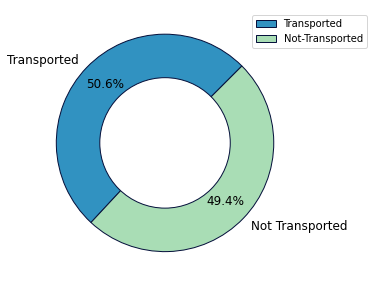

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(figsize=(5,5))

# Defind colours for print()
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    
print(color.BOLD+color.UNDERLINE+"Transported Status (%)"+color.END)
((df['Transported'].value_counts()/len(df['Transported']))*100).round(2)

# 0 = Not Transported 
# 1 = Transported 

default_status_count=[len(df[df.Transported==1]),len(df[df.Transported==0])]

ax=plt.pie(x = default_status_count, labels=['Transported', 'Not Transported '],
           autopct='%1.1f%%',colors = ['#3192C1', '#A9DDB5'], pctdistance=.77, startangle=45, textprops={"fontsize":12},
           wedgeprops={'edgecolor':'#06113C'}
)

plt.legend(['Transported', 'Not-Transported'], bbox_to_anchor=(.8, .99))

centre_circle = plt.Circle((0,0),0.6,fc='white', ec='#06113C')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


plt.show()


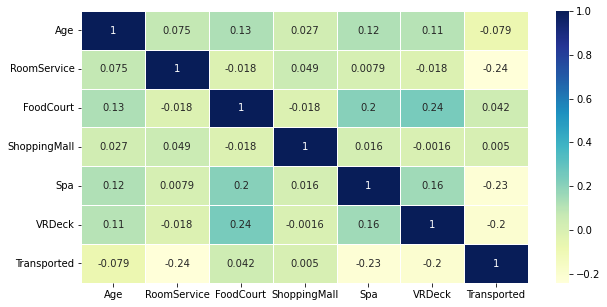

Transported     1.000000
RoomService     0.242162
Spa             0.226704
VRDeck          0.203433
Age             0.079067
FoodCourt       0.042338
ShoppingMall    0.005049
Name: Transported, dtype: float64


In [15]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)

corrMatrix = df.corr()
sns.heatmap(corrMatrix, linewidths=1, cmap="YlGnBu", annot=True)
plt.show()
print(corrMatrix["Transported"].abs().sort_values(ascending=False))

In [16]:
# Count the number of unique items in each columns:
df.nunique()

PassengerId     6954
HomePlanet         3
CryoSleep          2
Cabin           5474
Destination        3
Age               80
VIP                2
RoomService     1112
FoodCourt       1297
ShoppingMall     976
Spa             1165
VRDeck          1133
Name            6778
Transported        2
dtype: int64

In [17]:
df.value_counts()

PassengerId  HomePlanet  CryoSleep  Cabin    Destination    Age   VIP    RoomService  FoodCourt  ShoppingMall  Spa     VRDeck  Name                Transported
0001_01      Europa      False      B/0/P    TRAPPIST-1e    39.0  False  0.0          0.0        0.0           0.0     0.0     Maham Ofracculy     False          1
6168_02      Earth       False      G/999/S  55 Cancri e    12.0  False  0.0          0.0        0.0           0.0     0.0     Glenna Gordond      True           1
6167_01      Earth       True       G/998/S  PSO J318.5-22  42.0  False  0.0          0.0        0.0           0.0     0.0     Cellex Garrincent   True           1
6166_01      Earth       False      E/394/P  TRAPPIST-1e    25.0  False  980.0        0.0        3.0           0.0     0.0     Andan Handertiz     False          1
6163_01      Earth       False      E/409/S  TRAPPIST-1e    22.0  False  0.0          32.0       33.0          429.0   1174.0  Jodyn Briggins      False          1
                     

In [18]:
def count_how_many(df, feature):
    '''
    This function find how many observations of this feature was cancelled 
    input
    feature: a column from the dataframe
    output:
    Feature: dataframe with the number of cancellations
    '''
    Feature = df[['Transported',feature]].groupby(['Transported',feature]).size().reset_index(name = 'count')
    
    return Feature

In [19]:
count_how_many(df,'Age')

,Transported,Age,count
0,False,0.0,26
1,False,1.0,15
2,False,2.0,15
3,False,3.0,14
4,False,4.0,16
...,...,...,...
152,True,74.0,1
153,True,75.0,2
154,True,76.0,1
155,True,77.0,1


In [20]:
count = count_how_many(df, "Age")
count 

,Transported,Age,count
0,False,0.0,26
1,False,1.0,15
2,False,2.0,15
3,False,3.0,14
4,False,4.0,16
...,...,...,...
152,True,74.0,1
153,True,75.0,2
154,True,76.0,1
155,True,77.0,1


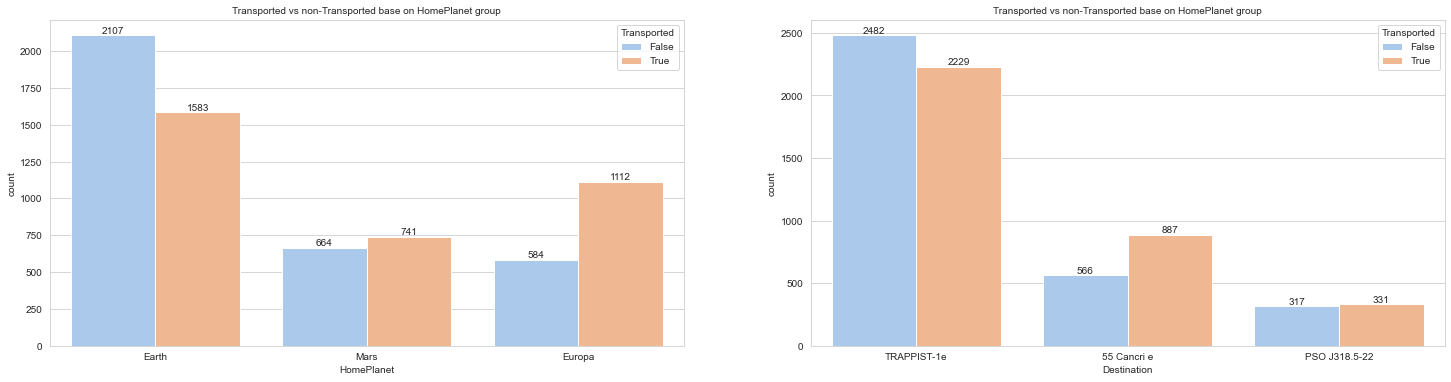

In [21]:
sns.set_style("whitegrid")
# sns.set_theme(style="darkgrid")
sns.set_palette("pastel")


fig, axes = plt.subplots(1,2,figsize=(25,6))

plot1 = sns.countplot(x=df['HomePlanet'],hue = df['Transported'], ax=axes[0])
axes[0].set_title("Transported vs non-Transported base on HomePlanet group", size=10)

plot2 = sns.countplot(x=df['Destination'],hue = df['Transported'], ax=axes[1])
axes[1].set_title("Transported vs non-Transported base on HomePlanet group", size=10)


plot1.bar_label(plot1.containers[0])
plot1.bar_label(plot1.containers[1])

plot2.bar_label(plot2.containers[0])
plot2.bar_label(plot2.containers[1])

plt.show()

- The bar plot on the **left** show that the majority of people who were transported come from Earth

- The bar plot on the **right** show that passenger who travel to **Trappist-1e** are more likely to be transported to a different dimension compare to passengers whose destinations is either **PSO** or **55 Cabcri e**

Text(0.5, 1.0, 'Transported vs non-Transported base on HomePlanet group')

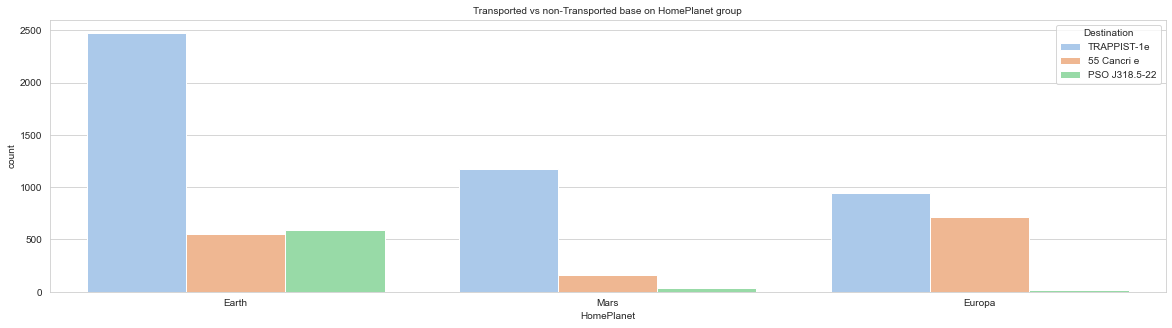

In [22]:
# let's explore how people from different HomePlanet will tend to travel to the tree destinations ? 

fig, axes = plt.subplots(1,1,figsize=(20,5))

sns.countplot(x=df['HomePlanet'], hue = df['Destination'], ax=axes)
axes.set_title("Transported vs non-Transported base on HomePlanet group", size=10)

# We can see that the majority of people who comes from Earth travel to Trappist 

# From previous plots, we can safetly assume that people who travel to Trappist and are from Earth are the majority that get transported to 
# another dimension. 

Text(0.5, 1.0, 'Total Transported vs non-Transported that are in CryoSleep')

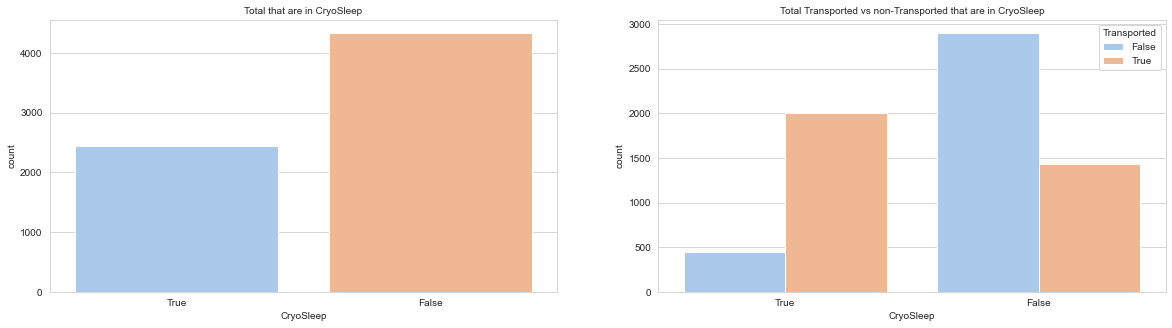

In [23]:
fig, axes = plt.subplots(1,2,figsize=(20,5))

sns.countplot(x=df['CryoSleep'], ax=axes[0])
axes[0].set_title("Total that are in CryoSleep", size=10)

sns.countplot(x=df['CryoSleep'],hue = df['Transported'], ax=axes[1])
axes[1].set_title("Total Transported vs non-Transported that are in CryoSleep", size=10)


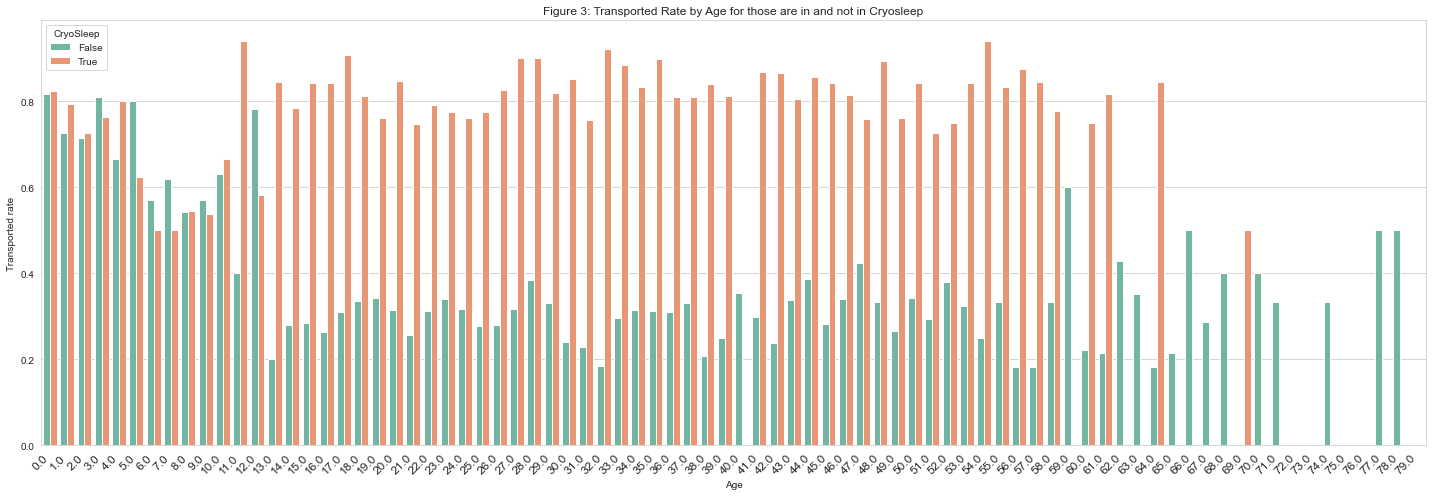

In [24]:
from matplotlib.ticker import FormatStrFormatter


plt.figure(figsize = (20,7))
trans_rate_age = df[['Transported', 'CryoSleep','Age']].groupby(
   ['Transported','CryoSleep', 'Age']).size().reset_index(name ='count')

trans_rate_age = trans_rate_age.pivot_table(
        index = ['CryoSleep', 'Age'], 
        columns ='Transported', 
       values = 'count').reset_index().rename(columns = {0:'not_Transported' ,1: 'Transported'})
trans_rate_age['trans_rate'] = trans_rate_age.Transported/ (trans_rate_age.Transported + trans_rate_age.not_Transported)

trans_rate_ax = sns.barplot(
    x = 'Age', 
    hue ='CryoSleep',
    y ='trans_rate',
    palette = sns.color_palette("Set2",2),
    data = trans_rate_age
)

plt.title('Figure 3: Transported Rate by Age for those are in and not in Cryosleep')
plt.xlabel('Age')
plt.ylabel('Transported rate')


trans_rate_ax.set_xticklabels(trans_rate_ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)
plt.tight_layout()

plt.show()

- Looking at Figure 3, we can confidently conclude that the majority of people are in CryoSleep that are in the age range (14 - 61) get transported the most.

- The rate of transportation for older people are less obvious but there are still some relatively high transportation rate for those in the age range 64 and 65.

- For people that are 40 years old, 97% of them is transported while in Cryosleep.

In [25]:
trans_rate_age.head(30)
# df.sort_values(by=['Age'])
df['Age'].value_counts().head(40)

18.0    261
24.0    252
21.0    244
23.0    240
19.0    236
22.0    225
28.0    220
20.0    219
26.0    216
27.0    206
25.0    200
29.0    183
32.0    166
31.0    162
33.0    146
37.0    142
0.0     140
30.0    138
36.0    135
35.0    129
15.0    128
38.0    122
17.0    119
16.0    119
34.0    119
39.0    114
13.0    114
14.0    107
41.0    107
40.0    106
43.0    103
42.0     98
44.0     88
46.0     72
49.0     69
47.0     68
45.0     67
4.0      62
50.0     61
3.0      61
Name: Age, dtype: int64

In [26]:
trans_rate_age

Transported,CryoSleep,Age,not_Transported,Transported,trans_rate
0,False,0.0,16.0,71.0,0.816092
1,False,1.0,6.0,16.0,0.727273
2,False,2.0,6.0,15.0,0.714286
3,False,3.0,4.0,17.0,0.809524
4,False,4.0,10.0,20.0,0.666667
...,...,...,...,...,...
149,True,72.0,NaN,2.0,NaN
150,True,73.0,NaN,1.0,NaN
151,True,75.0,NaN,2.0,NaN
152,True,76.0,NaN,1.0,NaN


<AxesSubplot:xlabel='Age', ylabel='count'>

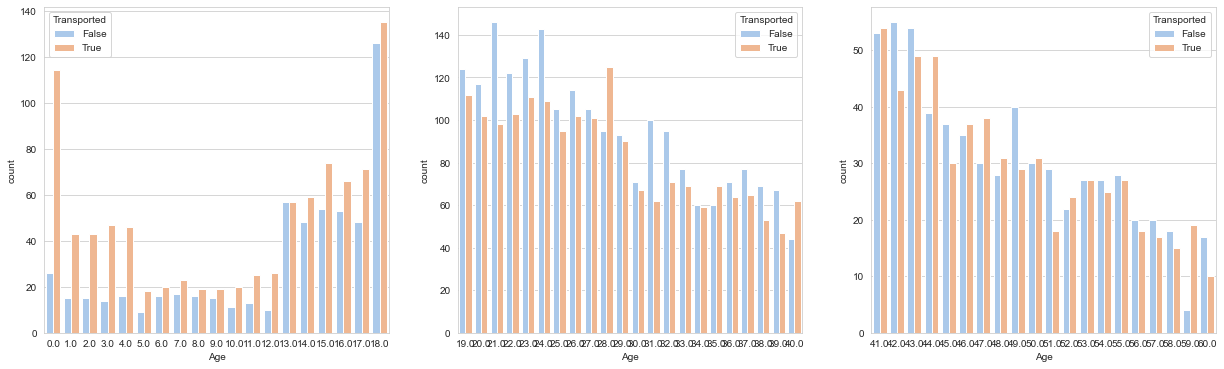

In [27]:


young = df[df["Age"] <= 18]
young_adult = df[(df["Age"] > 18) & (df["Age"] <= 40)]
adolescent = df[(df["Age"] > 40) & (df["Age"] <= 60)]
senior = df[df["Age"] > 60]

fig, axes = plt.subplots(1,3,figsize=(21,6))

sns.countplot(x=young['Age'],hue = young['Transported'], ax=axes[0])

sns.countplot(x=young_adult['Age'],hue = young_adult['Transported'], ax=axes[1])

sns.countplot(x=adolescent['Age'],hue = adolescent['Transported'], ax=axes[2])


C:\Users\ntc19\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


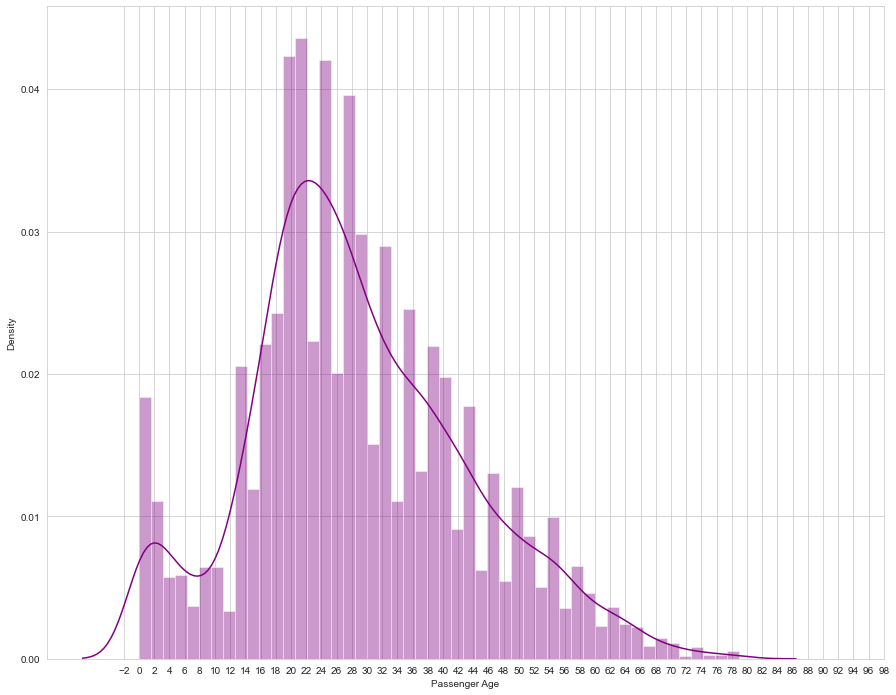

In [28]:
# This plot demonstrate the distribution of the Age of the Passengers. Note that this includes missing values. 

fig, ax = plt.subplots(figsize=(15,12))

sns.distplot(x=df.Age, bins = 50, color="purple")

ax.set_xticks(range(-2,100,2))
ax.set(xlabel='Passenger Age')

plt.show()

# Young people from the age of roughly 15 to 35 are among the most likely to be transported.

In [29]:
import scipy


stat, p = scipy.stats.shapiro(df.Age)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpretation
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=nan, p=1.000
Sample looks Gaussian (fail to reject H0)


C:\Users\ntc19\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Text(0.5, 1.0, 'Transported vs non-Transported base on HomePlanet group')

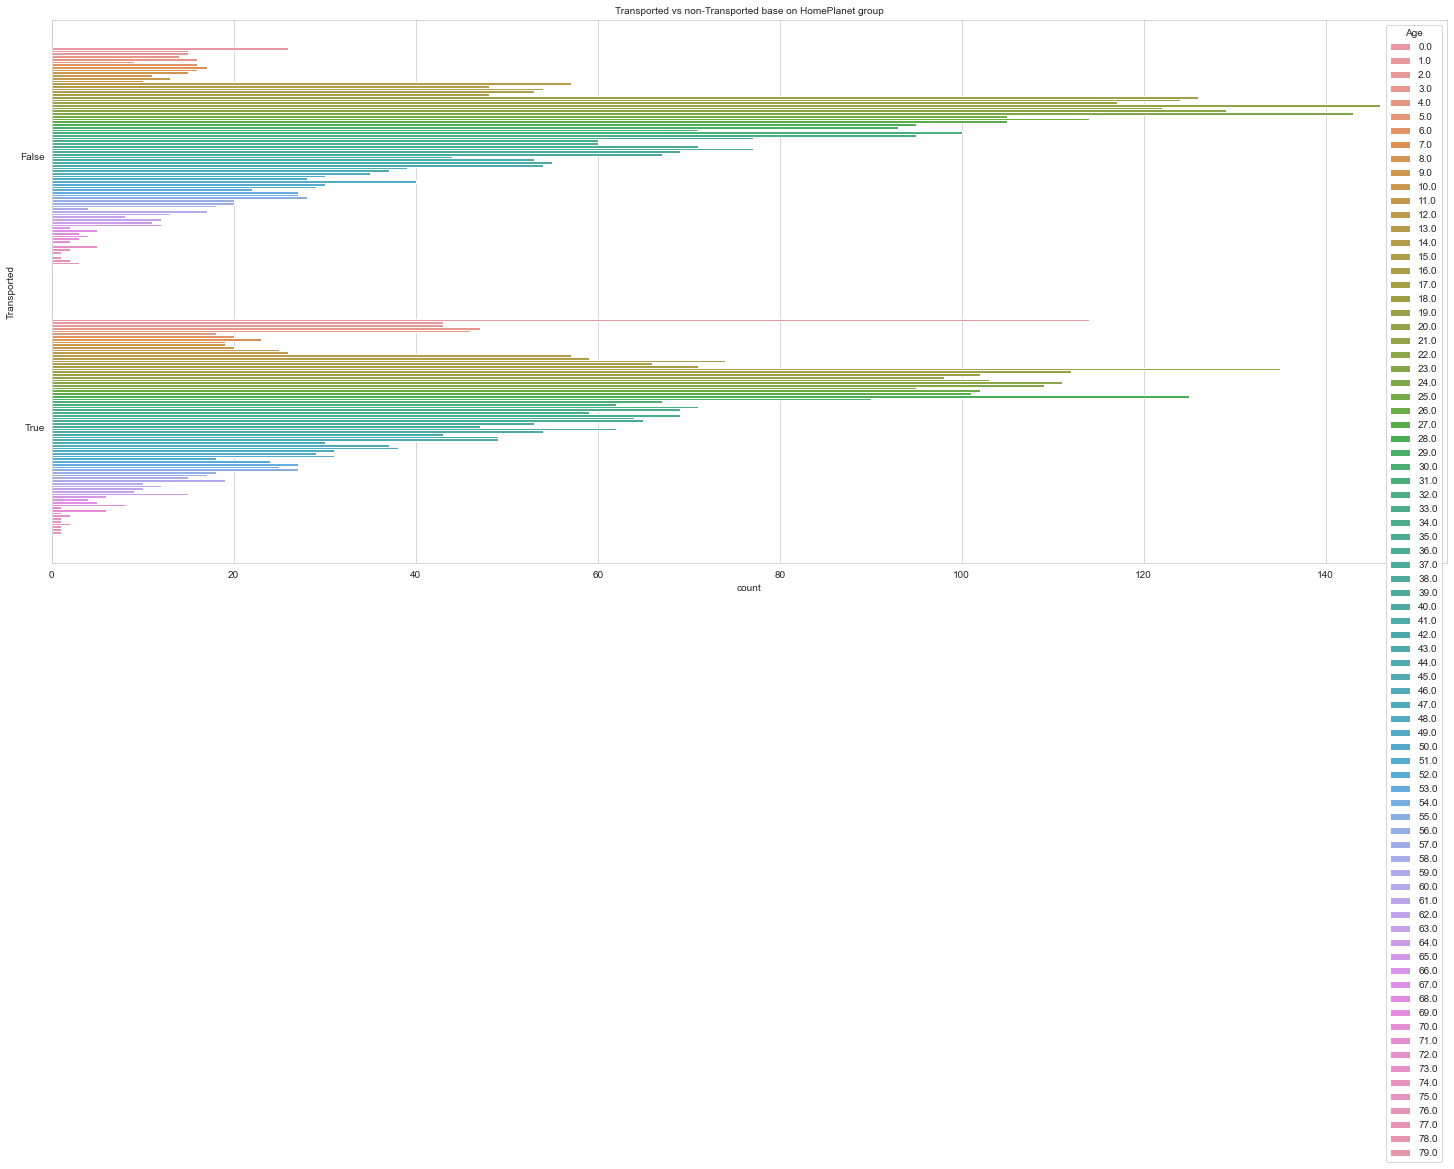

In [30]:
fig, axes = plt.subplots(1,1,figsize=(25,10))

sns.countplot(y=df['Transported'],hue = df['Age']).set_title("Transported vs non-Transported base on HomePlanet group", size=10)


<AxesSubplot:xlabel='Transported', ylabel='Age'>

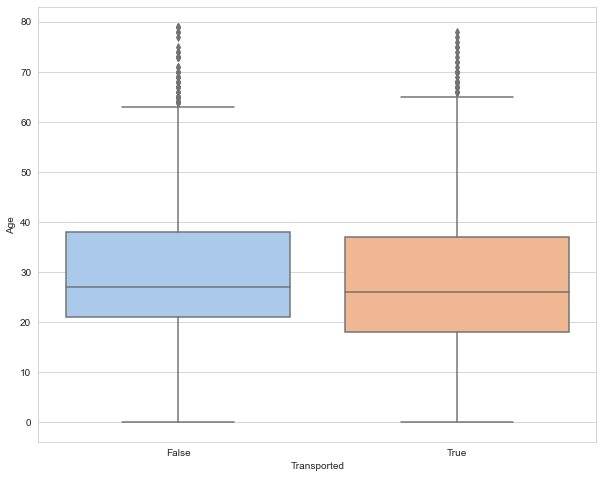

In [31]:
fig, axes = plt.subplots(1,1,figsize=(10,8))


sns.boxplot(x='Transported',y='Age', data=df,showfliers=True)

### TEXT ANALYSIS OF PASSENGER ID

In [32]:
# The end number of the ID indicate whether someone is in a group. We want to know if people who are single tend to disappear more
# than people who travel in groups

ID = df["PassengerId"]
ID.head(20)

0     1630_02
1     1169_01
2     5494_01
3     5133_07
4     5587_01
5     7890_01
6     3133_01
7     1452_03
8     0599_04
9     8701_01
10    1004_01
11    9231_03
12    5226_01
13    6492_01
14    1192_01
15    1764_01
16    6045_01
17    9183_01
18    2171_01
19    0549_02
Name: PassengerId, dtype: object

In [33]:
ID.str.len()

0       7
1       7
2       7
3       7
4       7
       ..
6949    7
6950    7
6951    7
6952    7
6953    7
Name: PassengerId, Length: 6954, dtype: int64

In [34]:
# TRY THINGS OUT

single = ID.str.contains('_01')
group = ~ID.str.contains('_01')  

group

0        True
1       False
2       False
3        True
4       False
        ...  
6949    False
6950     True
6951    False
6952    False
6953    False
Name: PassengerId, Length: 6954, dtype: bool

In [35]:
import numpy as np

df2 = df.copy()

df2['PassengerType'] = np.where(ID.str.contains('_01'), True, False)
df2['PassengerType'] = df2['PassengerType'].map({True: 'Single', False: 'Groups'})



cabin_side = df["Cabin"]
df2['CabinSide'] = np.where(cabin_side.str.contains('/P'), True, False)

df2['CabinSide'] = df2['CabinSide'].map({True: 'Port', False: 'Starboard'})

df2.dtypes


PassengerId       object
HomePlanet        object
CryoSleep         object
Cabin             object
Destination       object
Age              float64
VIP               object
RoomService      float64
FoodCourt        float64
ShoppingMall     float64
Spa              float64
VRDeck           float64
Name              object
Transported         bool
PassengerType     object
CabinSide         object
dtype: object

<AxesSubplot:xlabel='Deck', ylabel='Transported'>

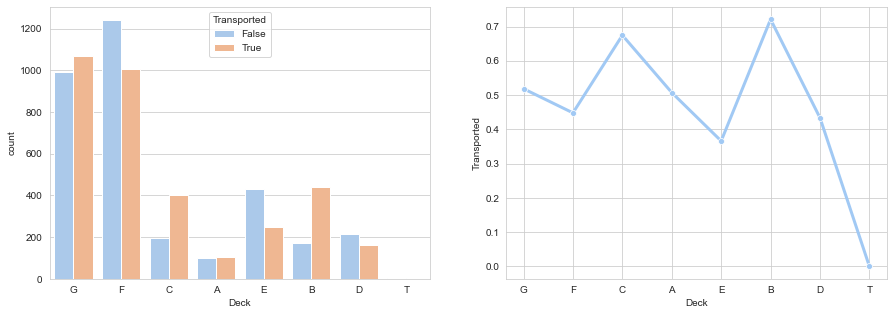

In [36]:
for dataset in df2:
    df2['Deck'] = df2['Cabin'].apply(lambda x: x.split('/')[0] if (str(x)) != 'nan' else x)
    

fig, axes = plt.subplots(1,2,figsize=(15,5))

sns.countplot(data = df2, x = "Deck", hue = "Transported", ax=axes[0])
sns.lineplot(x = "Deck", y = "Transported", data = df2, ci=None, linewidth=3, marker="o", ax=axes[1])

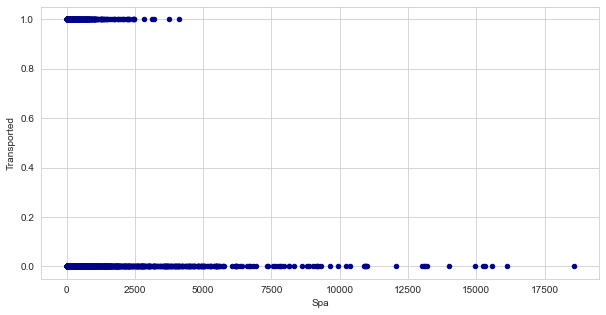

In [37]:
df2["Transported"] = df["Transported"].astype(int)

ax1 = df2.plot.scatter(x='Spa',
                      y= 'Transported',
                     c='DarkBlue')

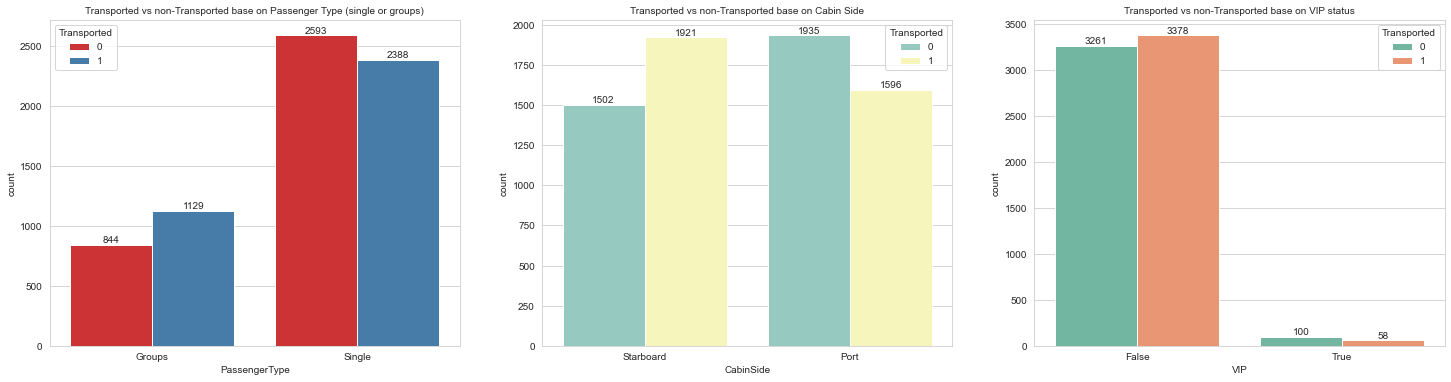

In [38]:
fig, axes = plt.subplots(1,3,figsize=(25,6))

plot4 = sns.countplot(x=df2['PassengerType'], hue = df2['Transported'], ax=axes[0], palette = sns.color_palette("Set1",2))
axes[0].set_title("Transported vs non-Transported base on Passenger Type (single or groups)", size=10)

plot5 = sns.countplot(x=df2['CabinSide'], hue = df2['Transported'], ax=axes[1], palette = sns.color_palette("Set3",2))
axes[1].set_title("Transported vs non-Transported base on Cabin Side", size=10)

plot6 = sns.countplot(x=df2['VIP'], hue = df2['Transported'], ax=axes[2], palette = sns.color_palette("Set2",2))
axes[2].set_title("Transported vs non-Transported base on VIP status", size=10)

plot4.bar_label(plot4.containers[0])
plot4.bar_label(plot4.containers[1])

plot5.bar_label(plot5.containers[0])
plot5.bar_label(plot5.containers[1])

plot6.bar_label(plot6.containers[0])
plot6.bar_label(plot6.containers[1])

plt.show()

**False** = not single 

**True** = single passenger

The plot above show that the number of people was transported in the single group were twice as many compare to people who travel in groups


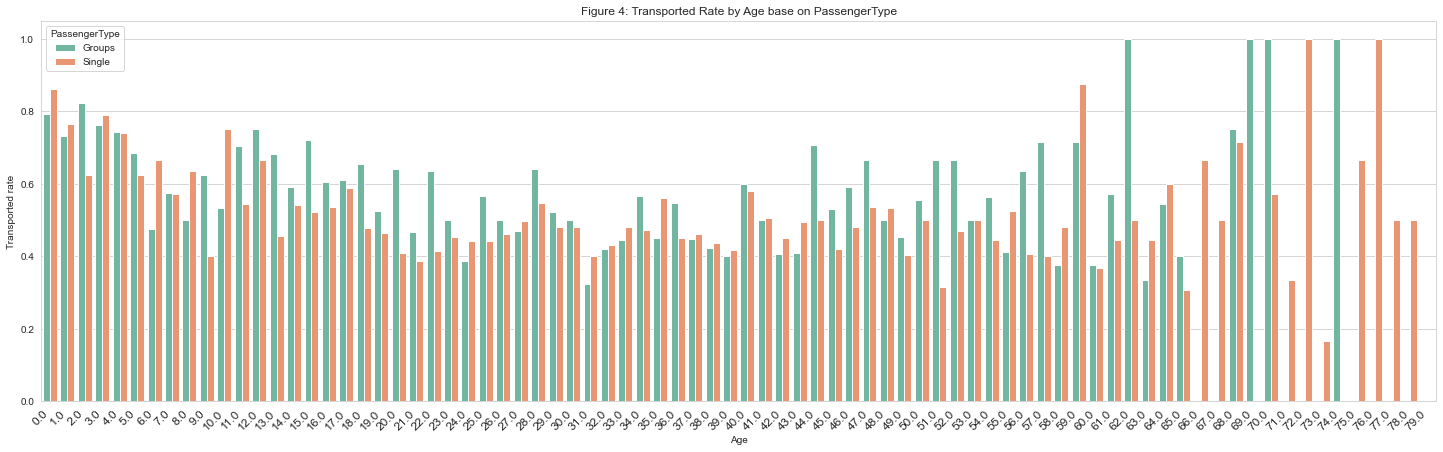

In [39]:
plt.figure(figsize = (25,7))
trans_rate_age2 = df2[['Transported', 'PassengerType','Age']].groupby(
   ['Transported','PassengerType', 'Age']).size().reset_index(name ='count')

trans_rate_age2 = trans_rate_age2.pivot_table(
        index = ['PassengerType', 'Age'], 
        columns ='Transported', 
       values = 'count').reset_index().rename(columns = {0:'not_Transported' ,1: 'Transported'}).fillna(0)
trans_rate_age2['trans_rate2'] = trans_rate_age2.Transported / (trans_rate_age2.Transported + trans_rate_age2.not_Transported)

trans_rate_ax2 = sns.barplot(
    x = 'Age', 
    hue ='PassengerType',
    y ='trans_rate2',
    palette = sns.color_palette("Set2",2),
    data = trans_rate_age2
)

plt.title('Figure 4: Transported Rate by Age base on PassengerType')
plt.xlabel('Age')
plt.ylabel('Transported rate')


trans_rate_ax2.set_xticklabels(trans_rate_ax2.get_xticklabels(), rotation=45, ha="right", fontsize=12)
# plt.tight_layout()

plt.show()

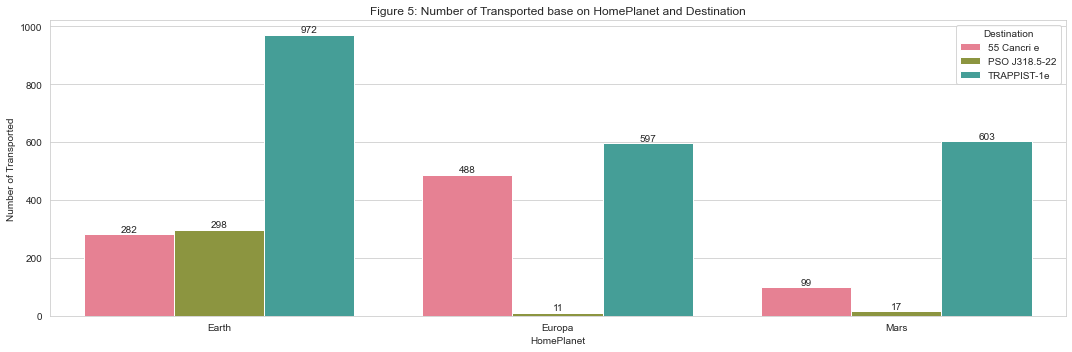

In [40]:
plt.figure(figsize = (15,5))
trans_rate_age3 = df[['Transported', 'HomePlanet','Destination']].groupby(
   ['Transported','HomePlanet', 'Destination']).size().reset_index(name ='count')

trans_rate_age3 = trans_rate_age3.pivot_table(
        index = ['HomePlanet', 'Destination'], 
        columns ='Transported', 
       values = 'count').reset_index().rename(columns = {0:'not_Transported' ,1: 'Transported'}).fillna(0)

trans_rate_age3['trans_rate3'] =  trans_rate_age3.Transported

trans_rate_ax3 = sns.barplot(
    x = 'HomePlanet', 
    hue = 'Destination',
    y = 'trans_rate3',
    palette = sns.color_palette("husl", 4),
    data = trans_rate_age3
)


trans_rate_ax3.bar_label(trans_rate_ax3.containers[0])
trans_rate_ax3.bar_label(trans_rate_ax3.containers[1])
trans_rate_ax3.bar_label(trans_rate_ax3.containers[2])

plt.title('Figure 5: Number of Transported base on HomePlanet and Destination')
plt.xlabel('HomePlanet')
plt.ylabel('Number of Transported')


plt.tight_layout()


    
plt.show()

From this, we can conclude that people who travel from **Earth** to **Trappist** make up the majority of the people who disappeared.


In [41]:
trans_rate_age3['trans_rate3']

0    282
1    298
2    972
3    488
4     11
5    597
6     99
7     17
8    603
Name: trans_rate3, dtype: int64

In [42]:
#Checking for columns with missing values and calculating the percentages
data = {'Missing value count': df.isnull().sum(), 'Percentage (%)': (df.isnull().sum()/df.shape[0]) * 100}
df_missing = pd.DataFrame(data=data)
print(df_missing[df_missing['Missing value count'] > 0])


              Missing value count  Percentage (%)
HomePlanet                    163        2.343975
CryoSleep                     178        2.559678
Cabin                         165        2.372735
Destination                   142        2.041990
Age                           151        2.171412
VIP                           157        2.257693
RoomService                   151        2.171412
FoodCourt                     138        1.984469
ShoppingMall                  162        2.329594
Spa                           154        2.214553
VRDeck                        147        2.113891
Name                          161        2.315214


<AxesSubplot:>

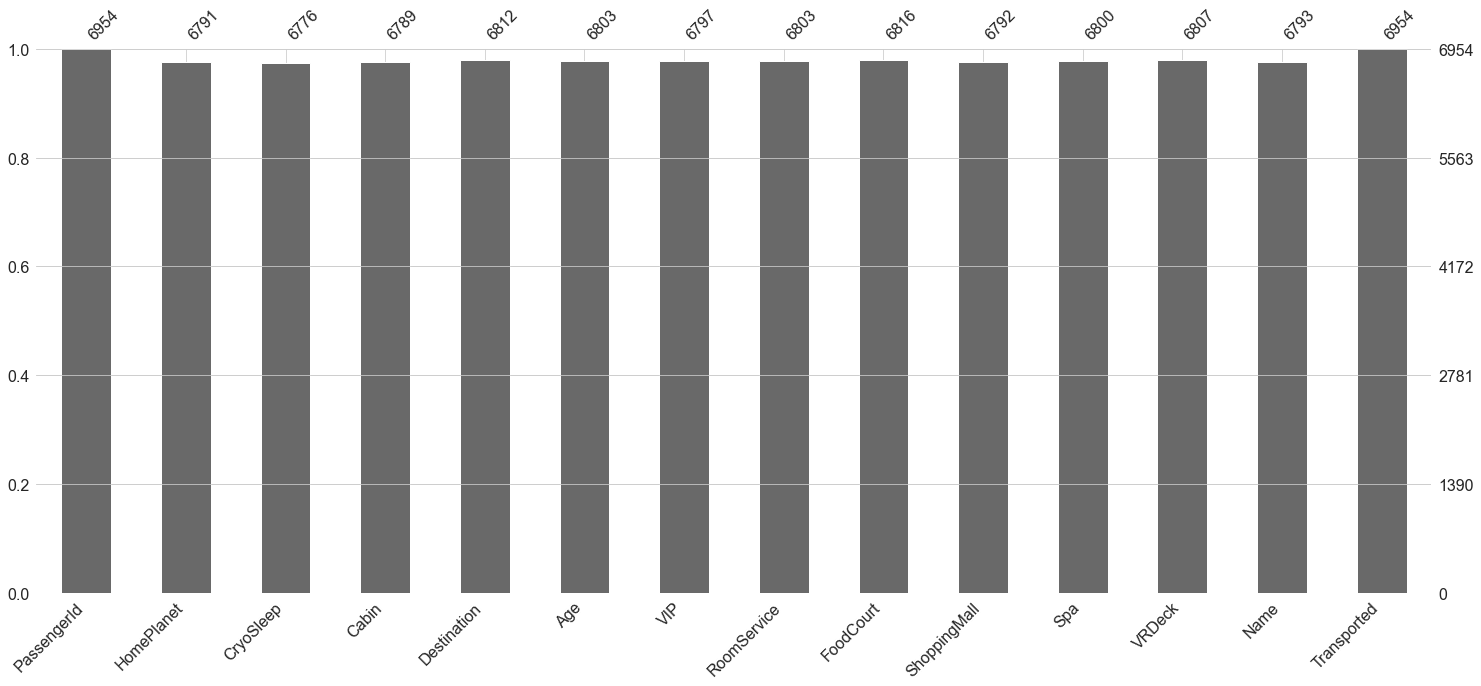

In [56]:


import missingno as msno
msno.bar(df)


<AxesSubplot:>

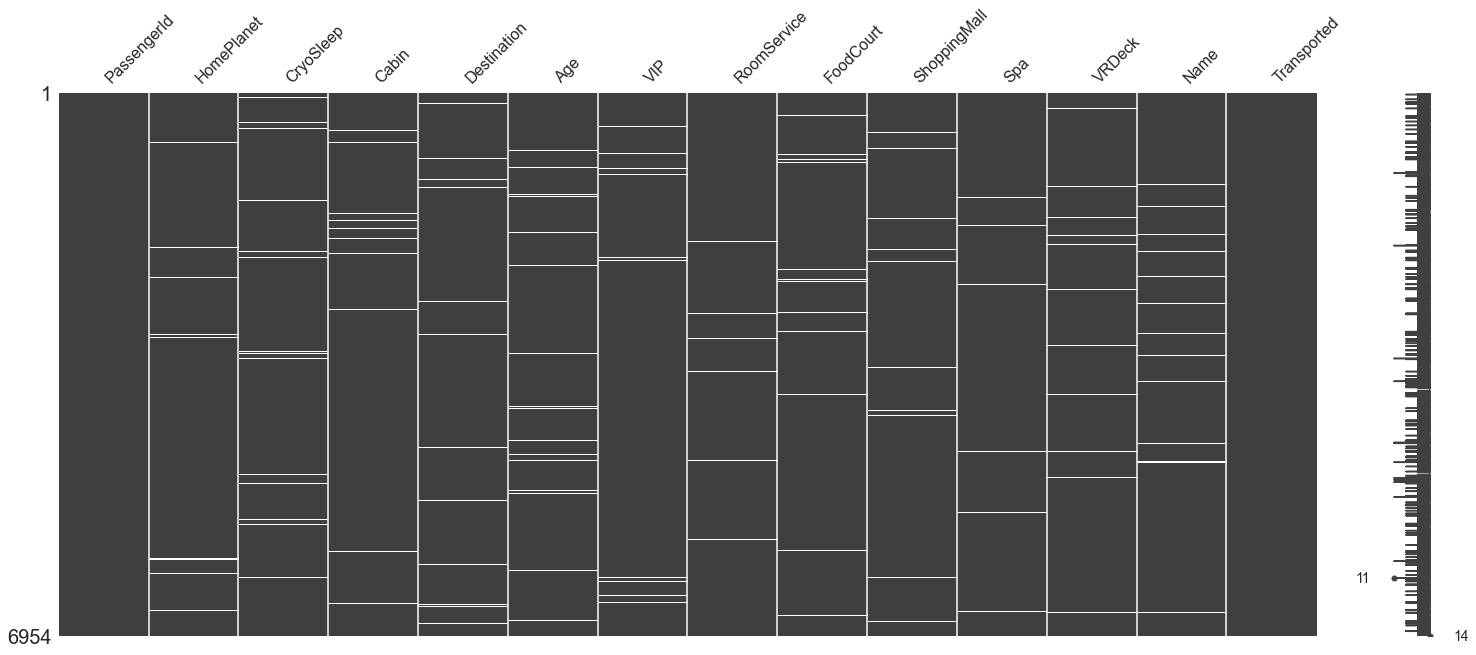

In [57]:
msno.matrix(df)


In [58]:
# df2.duplicated(subset=None, keep='first')

duplicate = df2[df2.duplicated()]
 
print("Duplicate Rows :")
 
# Print the resultant Dataframe
duplicate

Duplicate Rows :


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerType,CabinSide,Deck


### SPLIT HERE

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
df2['Transported'] = labelencoder.fit_transform(df2['Transported'])


# # Creating a 60 - 40 split between training and holdout set
# train_set, holdout = train_test_split(df_clean, test_size=0.4, random_state=1234)

# # Creatining 50 - 50 split between validation and test set
# val_set, test_set = train_test_split(holdout, test_size=0.5, random_state=1234)


# drop unwanter columns 


X = df2.drop(columns = ['Transported'])
y = df2.Transported

# Split the test data columns into output and features 
X_test = test_df.drop(columns = ['Transported'])
y_test = test_df.Transported

# Split the training data further into 60-20: 60 training and 20 validations + 20 test data from before
X_train, X_val, y_train, y_val = train_test_split(X,y, # data to split
                                                  test_size = 0.25,    # we will leave 25% to validate our models
                                                  random_state = 1234,  # make our work reproducable 
                                                  shuffle = True)     # prevent data ordering affecting our model




# reset the index so it goes from 0...n
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)


# # The hold-out set won't be touched until model selection.

# # Creating a 60 - 40 splits between train and hold-out sets
# X_train, X_hold_out, y_train, y_hold_out = train_test_split(X, y, test_size=0.4, random_state=1234)

# #Split the hold-out 50 - 50 into validation and test set 
# X_val, X_test, y_val, y_test = train_test_split(X_hold_out ,y_hold_out ,test_size=0.5, random_state=1234) # For model selection

# We verify that the training, validation and test set are split accordingly.
print(len(X_train), 'train samples')
print(len(X_val), 'validation samples')
print(len(test_df), 'test samples')
print(f'Percentage of train samples: {round(len(X_train) / len(df0)*100)}%')
print(f'Percentage of validation samples: {round(len(X_val) / len(df0)*100)}%')
print(f'Percentage of test samples: {round(len(test_df) / len(df0)*100)}%')


5215 train samples
1739 validation samples
1739 test samples
Percentage of train samples: 60%
Percentage of validation samples: 20%
Percentage of test samples: 20%


### FEATURE ENGINERRING

In [60]:
def impute_values(df):

    '''
    This function cleans the NA values present in a dataframe 
    If the column has numerical values, then it will fill the NA's with the median value.
    Else, it will fill the NA's with the mode value (categorical variables)
    input:
    df: pandas dataframe to clean
    output:
    df: cleaned pandas dataframe
    '''
    # Get the column names with NA values
    cols_na = [col for col in df.columns if df[col].isnull().any()]

    # Store the values to use for filling the NA's in a temporary dictionary
    values_dict = {}
    for i in cols_na:

        if df[i].dtype == "float64":
            clean_value = df[i].median()

        else:
            clean_value = df[i].mode()[0]
            
        values_dict[i] = clean_value
    
    # Replace the NA's with the dictionary
    df.fillna(value = values_dict, inplace = True)

    return df

In [61]:
# IMPUTE MISSING DATA

X_train = impute_values(X_train)

X_val = impute_values(X_val)

# X_test = impute_values(X_test)




In [62]:
data = {'Missing value count': X_train.isnull().sum(), 'Percentage (%)': (X_train.isnull().sum()/X_train.shape[0]) * 100}
df_missing = pd.DataFrame(data=data)
print(df_missing[df_missing['Missing value count'] >= 0])

               Missing value count  Percentage (%)
PassengerId                      0             0.0
HomePlanet                       0             0.0
CryoSleep                        0             0.0
Cabin                            0             0.0
Destination                      0             0.0
Age                              0             0.0
VIP                              0             0.0
RoomService                      0             0.0
FoodCourt                        0             0.0
ShoppingMall                     0             0.0
Spa                              0             0.0
VRDeck                           0             0.0
Name                             0             0.0
PassengerType                    0             0.0
CabinSide                        0             0.0
Deck                             0             0.0


In [63]:
# NOTE THAT df_clean ONLY CONTAIN THE TRAINING DATASET WITH THE TARGET COLUMN THAT HAS ALREADY BEEN DROPPED.

X_train.dtypes

PassengerId       object
HomePlanet        object
CryoSleep           bool
Cabin             object
Destination       object
Age              float64
VIP                 bool
RoomService      float64
FoodCourt        float64
ShoppingMall     float64
Spa              float64
VRDeck           float64
Name              object
PassengerType     object
CabinSide         object
Deck              object
dtype: object

In [64]:
header = "Dataset information"
print(header)
print("="*len(header))

# Printing data set dimensions
print("Number of rows: ", X_train.shape[0])
print("Number of columns: ", X_train.shape[1])
print("Column names:", )
for i in X_train.columns:
    print(i, end = ",")

Dataset information
Number of rows:  5215
Number of columns:  16
Column names:
PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,PassengerType,CabinSide,Deck,

# DIMENSIONALITY REDUCTION

In [65]:
# TESTING PCA


features = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

var = X_train.copy()

var = var.loc[:, features]

# Standardize
var_scaled = (var - var.mean(axis=0)) / var.std(axis=0)

from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
var_pca = pca.fit_transform(var_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(var_pca.shape[1])]
var_pca = pd.DataFrame(var_pca, columns=component_names)

len(var_pca.index)

5215

In [66]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=var.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5
RoomService,-0.041962,0.688498,-0.716096,-0.104684,0.021366
FoodCourt,0.617927,-0.060176,-0.044663,-0.182616,0.761053
ShoppingMall,0.005680,0.703297,0.696479,-0.128593,0.061015
Spa,0.522635,0.161980,0.000463,0.808256,-0.217570
VRDeck,0.585854,-0.038535,-0.011348,-0.534676,-0.607686


array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

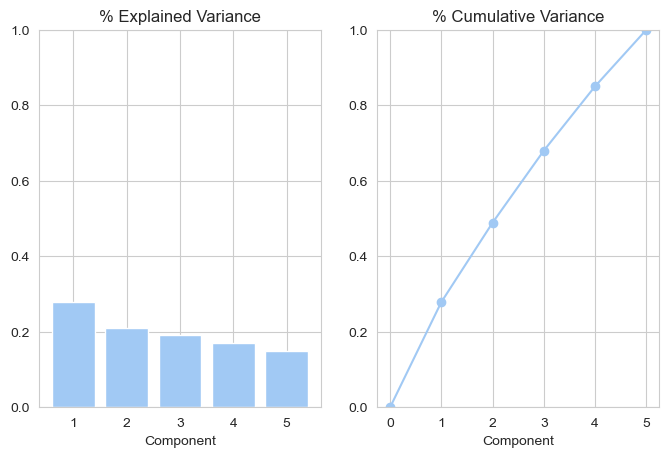

In [67]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

plot_variance(pca)

sources: 

https://towardsdatascience.com/a-complete-guide-to-principal-component-analysis-pca-in-machine-learning-664f34fc3e5a

https://www.kaggle.com/code/nirajvermafcb/principal-component-analysis-explained/notebook

https://www.kaggle.com/code/ryanholbrook/principal-component-analysis/tutorial

## MUTUAL INFORMATION

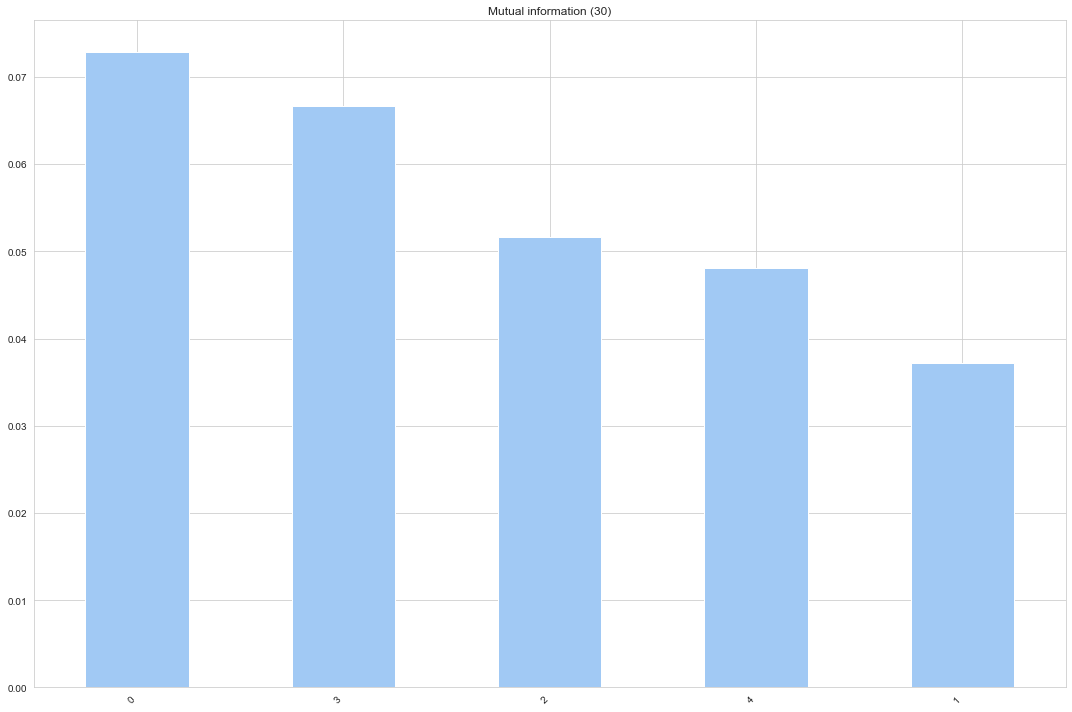

In [68]:
from sklearn.feature_selection import mutual_info_classif

plt.figure(figsize=(15,10))

mi = mutual_info_classif(var_scaled, y_train)
mi_series = pd.Series(mi).sort_values(ascending = False)

# lets plot the top 30
PLOT_NUM = 30
mi_series[:PLOT_NUM].plot.bar(legend = False, figsize=(15,10))
plt.title('Mutual information (' + str(PLOT_NUM) + ')')

plt.xticks(rotation=45,ha='right')
plt.tight_layout()
#plt.savefig('mutual_information.png', dpi=300)
plt.show()

In [69]:
%%time
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 1234

# create a forest classifier
forest = RandomForestClassifier(criterion='gini',
                                n_estimators=1000,
                                max_features = 'sqrt',
                                random_state=RANDOM_STATE,
                                n_jobs=-1)

# fit the classifier
forest.fit(var_scaled, y_train)

# get the importances for the features
importances = forest.feature_importances_

importances_series = pd.Series(importances).sort_values(ascending = False)

Wall time: 1.55 s


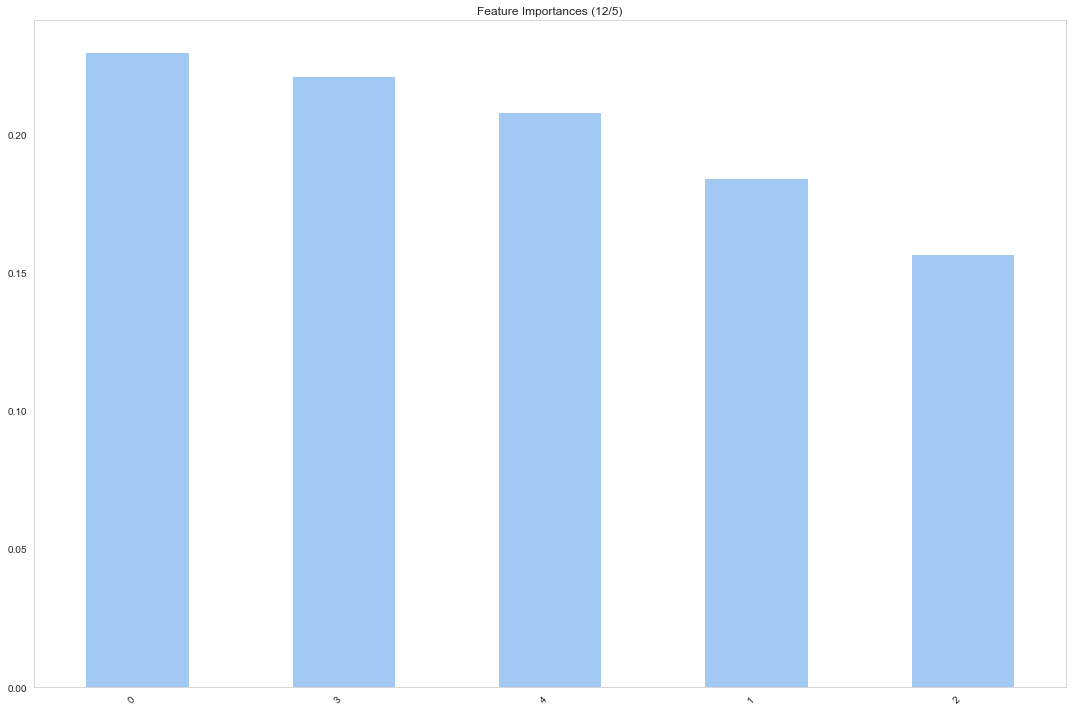

In [70]:
PLOT_LIMIT = 12

# plot the important features
plt.figure(figsize=(15,10))
importances_series[:PLOT_LIMIT].plot.bar(legend =False, grid=False)
plt.title('Feature Importances ('+str(PLOT_LIMIT)+'/'+str(len(importances_series))+')')

plt.xticks(rotation=45,ha='right')
plt.tight_layout()

plt.savefig('forest_importances.png', dpi=300)
plt.show()

In [71]:
df3 = X_train

# Feature transformation and drop ID, Name and Cabin

In [72]:
# One hot encode cat features
cat_feat=["HomePlanet", "Destination", "Deck"]

X_train = pd.get_dummies(X_train, columns=cat_feat, drop_first = True)

X_val = pd.get_dummies(X_val, columns=cat_feat, drop_first = True)



# Feature transformation 
X_train['PassengerType'] = X_train['PassengerType'].replace(['Single', 'Groups'], [1, 0])
X_train['CabinSide'] = X_train['CabinSide'].replace(['Port', 'Starboard'], [1, 0])

# X_train['HomePlanet'] = X_train['HomePlanet'].replace(['Earth', 'Europa', 'Mars'], [2, 1, 0])
# X_train['Destination'] = X_train['Destination'].replace(['TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22'], [2, 1, 0])

# Drop Features that have already been transformed into integer
X_train = X_train.drop(columns = ["PassengerId", "Cabin", "Name"])


######################################################################

X_val['PassengerType'] = X_val['PassengerType'].replace(['Single', 'Groups'], [1, 0])
X_val['CabinSide'] = X_val['CabinSide'].replace(['Port', 'Starboard'], [1, 0])

# X_val['HomePlanet'] = X_val['HomePlanet'].replace(['Earth', 'Europa', 'Mars'], [2, 1, 0])
# X_val['Destination'] = X_val['Destination'].replace(['TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22'], [2, 1, 0])

# Drop Features that have already been transformed into integer
X_val = X_val.drop(columns = ["PassengerId", "Cabin", "Name"])

###################################################################################################

# X_test['PassengerType'] = X_test['PassengerType'].replace(['Single', 'Groups'], [1, 0])
# X_test['CabinSide'] = X_test['CabinSide'].replace(['Port', 'Starboard'], [1, 0])

# X_test['HomePlanet'] = X_test['HomePlanet'].replace(['Earth', 'Europa', 'Mars'], [2, 1, 0])
# X_test['Destination'] = X_test['Destination'].replace(['TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22'], [2, 1, 0])

# #Drop Features that have already been transformed into integer
# X_test = X_test.drop(columns = ["PassengerId", "Cabin", "Name"])








In [73]:
#Convert some columns to int because machine learning dont take in BOolean values

X_train[['CryoSleep', 'VIP']] = (X_train[['CryoSleep', 'VIP']] == 'TRUE').astype(int)

X_val[['CryoSleep', 'VIP']] = (X_val[['CryoSleep', 'VIP']] == 'TRUE').astype(int)

# X_test[['CryoSleep', 'VIP']] = (X_test[['CryoSleep', 'VIP']] == 'TRUE').astype(int)

In [74]:
# MODEL PERFORMANCE

import sklearn

def roc_plot(y_true, y_pred):
    """ Draw an ROC curve and report AUC
    """
    roc = pd.DataFrame(
        data = np.c_[sklearn.metrics.roc_curve(y_true, y_pred)],
        columns = ('fpr', 'tpr', 'threshold')
    )
    
    sns.lineplot(x='fpr', y='tpr', data=roc, ci=None)


    plt.plot([0,1],[0,1], 'k--', alpha=0.5) # 0-1 line 
    plt.title("ROC curve (auc = %.4f)" % sklearn.metrics.roc_auc_score(y_true, y_pred))
             
    plt.show()

from sklearn.metrics import classification_report, confusion_matrix
#Function returns confusion matrix and classification report for the model
def assess_model(actual, pred):
    print("Confusion Matrix:\n", confusion_matrix(actual, pred), "\n")
    print("Classification Report:\n", classification_report(actual, pred))

### TESTING DATA HERE

In [75]:
# #Cleaning up TEST data (similar to the train data) ready for model 

# df_test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

# df_test_copy = df_test.copy()


# ID = df_test_copy["PassengerId"]
# df_test_copy['PassengerType'] = np.where(ID.str.contains('_01'), True, False)


# cabin_side = df_test_copy ["Cabin"]
# df_test_copy['CabinSide'] = np.where(cabin_side.str.contains('/P'), True, False)


# df_test_copy['HomePlanet'] = df_test_copy['HomePlanet'].replace(['Earth', 'Europa', 'Mars'], [2, 1, 0])
# df_test_copy['Destination'] = df_test_copy['Destination'].replace(['TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22'], [2, 1, 0])


# # Drop Features that have already been transformed into integer
# df_test_drop = df_test_copy.drop(columns = ["PassengerId", "Cabin", "Name"])


# df_test_clean = impute_values(df_test_drop)


# df_test_clean.dtypes

# #CHECK FOR MISSING VALUES
# percent_missing = df_test_clean.isnull().sum() * 100 / len(df_test_clean)
# missing_value_df = pd.DataFrame({'column_name': df_test_clean.columns,
#                                  'percent_missing': percent_missing})

# percent_missing


### LOGISTIC REGRESSION

In [76]:
#baseline model 
import warnings

warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold

m_baseline = LogisticRegression(solver='lbfgs', max_iter=2000).fit(X_train, y_train)
assess_model(y_val, m_baseline.predict(X_val))


Confusion Matrix:
 [[656 214]
 [168 701]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.75      0.77       870
           1       0.77      0.81      0.79       869

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



In [77]:
# Hyper parameter tuning:

# Increase max iter to 4000 resolve the LineSearch Warning errors.

# Dont have to parameter tuning until you have found a model with the highest accuracy. In the future, if you found a non-tune model 
# that can perform better than your current well tuned one then you have wasted computational time 
# and efforts for the model that you will never use. 

model = LogisticRegression(max_iter = 4000)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01] # this is the lambda penalty term in the objective function.

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state= 1234)

grid_search = GridSearchCV(estimator = model, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'accuracy',error_score = 0)
grid_result = grid_search.fit(X_train, y_train)


# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.785368 using {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.782938 (0.018008) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.782554 (0.015720) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.782875 (0.017135) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.783130 (0.017951) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.781916 (0.016788) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.782620 (0.017530) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.783834 (0.017916) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.783130 (0.016389) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.783322 (0.016949) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.785368 (0.017593) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.785047 (0.017261) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.783322 (0.017177) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.783259 (0.018201) wit

In [78]:
m_baseline = LogisticRegression(penalty='l2', C = 1.0, solver='liblinear', max_iter = 4000).fit(X_train, y_train)

assess_model(y_val, m_baseline.predict(X_val))


Confusion Matrix:
 [[649 221]
 [168 701]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.75      0.77       870
           1       0.76      0.81      0.78       869

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



In [79]:
# plt.figure(figsize = (10,5))

# roc_plot(y_test, m_baseline.predict(X_test))

In [80]:
X_train

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,PassengerType,CabinSide,...,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
0,0,24.0,0,332.0,9.0,356.0,0.0,0.0,1,1,...,0,0,1,0,0,0,0,1,0,0
1,0,38.0,0,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,0,19.0,0,0.0,6.0,0.0,0.0,1179.0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0,32.0,0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,23.0,0,0.0,0.0,0.0,0.0,0.0,1,1,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5210,0,24.0,0,0.0,0.0,0.0,0.0,0.0,1,1,...,0,1,0,0,0,0,0,0,1,0
5211,0,60.0,0,0.0,0.0,0.0,0.0,0.0,1,1,...,1,0,1,0,0,0,0,1,0,0
5212,0,36.0,0,0.0,0.0,0.0,0.0,0.0,1,1,...,1,0,1,0,0,0,0,1,0,0
5213,0,28.0,0,0.0,0.0,0.0,0.0,0.0,1,1,...,0,0,1,0,0,0,0,0,1,0


### NAIVE BAYES CLASSIFIER 

Note: Naive Bayes assume independnt among the features. If you choose NB as your algorithms, make sure to check for the independent hypothesis

In [81]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train_NB = scaler.fit_transform(X_train)

X_val_NB = scaler.transform(X_val)

In [82]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train_NB, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(X_val_NB)



In [83]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(gnb.score(X_train_NB, y_train)))

print('Validation set score: {:.4f}'.format(gnb.score(X_val_NB, y_val)))

Training set score: 0.6596
Validation set score: 0.6463


In [84]:
from sklearn.metrics import confusion_matrix,accuracy_score
cm = confusion_matrix(y_val, y_pred)
ac = accuracy_score(y_val,y_pred)

<AxesSubplot:>

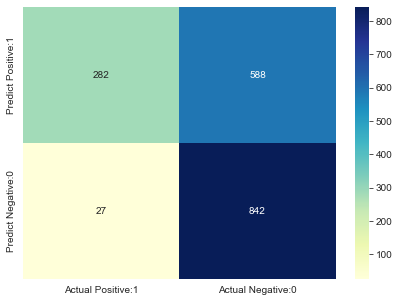

In [85]:
# visualize confusion matrix with seaborn heatmap

plt.figure(figsize = (7,5))

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [86]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.32      0.48       870
           1       0.59      0.97      0.73       869

    accuracy                           0.65      1739
   macro avg       0.75      0.65      0.61      1739
weighted avg       0.75      0.65      0.61      1739



### RANDOM FOREST MODEL

In [87]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


# Grid search for Random forest using max_depth, n_estimators and max_features
rf_gs = GridSearchCV(
    make_pipeline(
        StandardScaler(), 
        RandomForestClassifier(criterion="gini", bootstrap=True)
        ),
    param_grid={
        "randomforestclassifier__max_depth": [5, 10, 20],
        "randomforestclassifier__n_estimators": [10, 20, 50, 100],
        "randomforestclassifier__max_features": [2, 5, 10, 15, 18]},
    cv=KFold(5, shuffle=True, random_state=1234),
    scoring="accuracy"
    ).fit(X_train, y_train)

In [88]:
rf_gs.best_params_

{'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__max_features': 5,
 'randomforestclassifier__n_estimators': 100}

In [89]:
rf_mdl = make_pipeline(
        StandardScaler(), 
        RandomForestClassifier(
            n_estimators = 100,
            max_depth = 10, 
            max_features = 5 )
        ).fit(X_train, y_train)

In [90]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix


def model_assessment(model, X, y):

    cm = plot_confusion_matrix(model, X, y, display_labels = ["not_Transported", "Transported"], cmap = plt.cm.Blues, normalize = "true")
    y_pred = model.predict(X)
    print("Accuracy score: ", accuracy_score(y, y_pred))

    return cm

Accuracy score:  0.7987349051178838


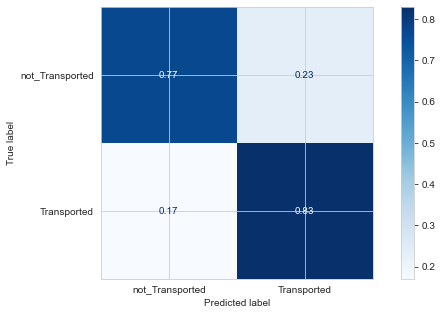

In [91]:
model_assessment(rf_mdl, X_val, y_val)
plt.show()

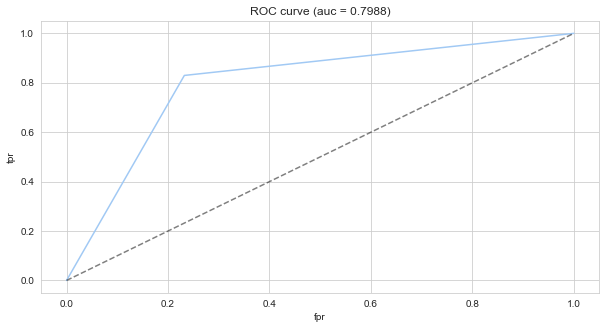

In [102]:
plt.figure(figsize = (10,5))

roc_plot(y_val, rf_mdl.predict(X_val))

In [94]:
# from sklearn.model_selection import RandomizedSearchCV, KFold, StratifiedKFold

# parameters={'n_estimators' : [100,250,500,750],'max_features': [2,5,10,15], 'max_depth':[5,10,15,20,25]}
# ran_search=RandomizedSearchCV(m_rf , parameters, n_iter=10, scoring="f1", n_jobs = -1).fit(X_train, y_train)

# print("The best classifier is: ", ran_search.best_params_)

In [95]:
# print("Best cross-validation score: {:.4f}".format(ran_search.best_score_))

# m_tuned = RandomForestClassifier(criterion="gini", n_estimators = 500, max_features= 5, max_depth = 10).fit(X_train, y_train)

# print(assess_model(y_val,m_tuned.predict(X_val)))

In [96]:
# plt.figure(figsize = (10,5))
# roc_plot(y_test, m_tuned.predict(X_test))

### K-NEAREST NEIGHBOR

In [97]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn import datasets
from sklearn.metrics import accuracy_score

# Feature Scaling using StandardScaler
#
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_val_std = sc.transform(X_val)
#
# Fit the model
#
knn = KNeighborsClassifier(n_neighbors = 4, p = 2, weights = 'distance', algorithm = 'auto')
knn.fit(X_train_std, y_train)
#
# Evaluate the training and test score
#
print('Training accuracy score: %.3f' % knn.score(X_train_std, y_train))
print('Validation accuracy score: %.3f' % knn.score(X_val_std, y_val))

Training accuracy score: 0.951
Validation accuracy score: 0.729


### ENSEMBLE STACKING

>lr 0.782 (0.017)
>knn 0.737 (0.017)
>cart 0.718 (0.022)
>svm 0.782 (0.016)
>random_forest 0.797 (0.015)


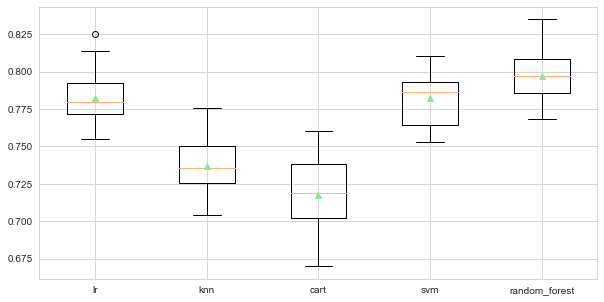

In [98]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot
 

# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svm'] = SVC()
    models['random_forest'] = RandomForestClassifier(criterion="gini", n_estimators = 500, max_features= 5, max_depth = 10)
    return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1234)
    scores = cross_val_score(model, X_train_std, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores
 

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_val_std, y_val)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>lr 0.782 (0.017)
>knn 0.737 (0.017)
>cart 0.718 (0.020)
>svm 0.782 (0.016)
>random_forest 0.798 (0.015)
>stacking 0.796 (0.015)


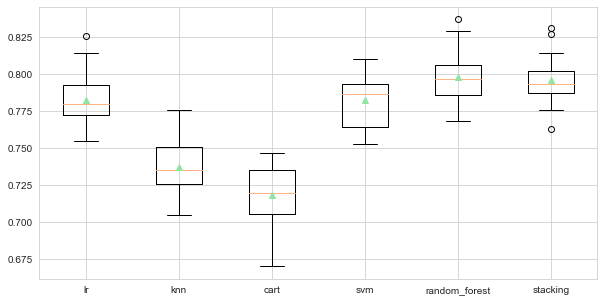

In [99]:
# compare ensemble to each baseline classifier
 

# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lr', LogisticRegression()))
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('cart', DecisionTreeClassifier()))
    level0.append(('svm', SVC()))
    level0.append(('bayes', RandomForestClassifier(criterion="gini", n_estimators = 500, max_features= 5, max_depth = 10)))
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model
 
# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svm'] = SVC()
    models['random_forest'] = RandomForestClassifier(criterion="gini", n_estimators = 500, max_features= 5, max_depth = 10)
    models['stacking'] = get_stacking()
    return models


# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_val_std, y_val)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

### NEURAL NETWORK MODEL

In [109]:
import tensorflow
from tensorflow.keras import callbacks

# YOUR CODE HERE: define an early stopping callback
early_stopping = early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,)

In [110]:
from keras.models import Sequential
from keras.layers import Dense

# define the keras model
model = Sequential()


model.add(Dense(12, input_dim = 21, activation='relu'))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(4, activation='sigmoid'))
model.add(Dense(1))

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset

model.fit(X_train, y_train, epochs=150, batch_size=100, callbacks=[early_stopping], verbose = 0)

# evaluate the keras model
_, accuracy = model.evaluate(X_val, y_val)
print('Accuracy: %.2f' % (accuracy*100))

55/55 [==============================] - 0s 702us/step - loss: 0.4503 - accuracy: 0.7907
Accuracy: 79.07


In [111]:
model.save('neural_net')

INFO:tensorflow:Assets written to: neural_net\assets


In [112]:
import tensorflow as tf
new_model = tf.keras.models.load_model('neural_net')

In [117]:
# import numpy as np 
# lil_x = np.asarray(df_test_clean).astype('float32')

# predict = new_model.predict([lil_x])
# # print(predict)

# print(np.argmax(predict))

In [118]:
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras import callbacks

# model1 = keras.Sequential([
#     layers.Dense(12, activation='relu', input_shape = (1,21)),
#     layers.Dense(64, activation='relu'),    
#     layers.Dense(1)
# ])
# model1.compile(
#     optimizer='adam',
#     loss='mae',
# )
# history = model1.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     batch_size=250,
#     epochs=50,
#     callbacks=[early_stopping]
# )

# history_df = pd.DataFrame(history.history)
# history_df.loc[:, ['loss', 'val_loss']].plot()
# print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [116]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print(val_loss, val_acc)

55/55 [==============================] - 0s 665us/step - loss: 0.4503 - accuracy: 0.7907
0.45026370882987976 0.7906842827796936


In [ ]:
# val_loss, val_acc = model.evaluate(X_test, y_test)
# print(val_loss, val_acc)

### XGBOOST

In [119]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_val)

predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_val, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

ModuleNotFoundError: No module named 'xgboost'

### CATEGORICAL-BOOST

In [120]:
X_train_without_pre = df3.drop(columns = ["PassengerId", "Cabin", "Name"])


X_train_without_pre['HomePlanet'] = X_train_without_pre['HomePlanet'].replace(['Earth', 'Europa', 'Mars'], [2, 1, 0])
X_train_without_pre['Destination'] = X_train_without_pre['Destination'].replace(['TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22'], [2, 1, 0])

X_train_without_pre

X_train_without_pre['PassengerType'] = X_train_without_pre['PassengerType'].replace(['Single', 'Groups'], [1, 0])
X_train_without_pre['CabinSide'] = X_train_without_pre['CabinSide'].replace(['Port', 'Starboard'], [1, 0])

In [121]:
# catboost for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot

# evaluate the model
model = CatBoostClassifier(verbose=0, n_estimators=100)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1234)
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

# fit the model on the whole dataset
model = CatBoostClassifier(verbose=0, n_estimators=100)
model.fit(X_train, y_train)


ModuleNotFoundError: No module named 'catboost'

# Gradient boosting

In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot

# evaluate the model
model = GradientBoostingClassifier()

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1234)
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


# fit the model on the whole dataset
model = GradientBoostingClassifier()
model.fit(X_train, y_train)


### Tuning hyper param

In [ ]:
LR = {'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 'n_estimators': [10,50,100, 150, 200, 250]}

tuning = GridSearchCV(estimator = GradientBoostingClassifier(),
                     param_grid = LR, scoring = 'r2', cv = None)

tuning.fit(X_train, y_train)
tuning.best_params_, tuning.best_score_

In [ ]:
model = GradientBoostingClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state = 1234)
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


# fit the model on the whole dataset
model = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 200)
model.fit(X_train, y_train)

## TESTING SOFT AND HARD VOTING

In [122]:
from sklearn.model_selection import cross_val_score

#Common Model Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Defining a list of Machine Learning Algorithms I will be running
MLA = [
    LogisticRegression(max_iter = 2000),
    SVC(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    LGBMClassifier(),
#     CatBoostClassifier() Running CatBoost causes error
]

row_index = 0

# Setting up the table to compare the performances of each model
MLA_cols = ['Model', 'Accuracy']
MLA_compare = pd.DataFrame(columns = MLA_cols)

# Iterate and store scores in the table
for model in MLA:
    MLA_compare.loc[row_index, 'Model'] = model.__class__.__name__
    cv_results = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    MLA_compare.loc[row_index, 'Accuracy'] = cv_results.mean()
    
    row_index+=1

# Present table
MLA_compare.sort_values(by=['Accuracy'], ascending=False, inplace=True)
MLA_compare

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
lgbm = LGBMClassifier()

boost_grid = {'n_estimators': [100, 500, 1000],
              'max_depth': [4, 8, 12],
              'learning_rate': [0.01, 0.05, 0.1, 0.15]}

lgbm_optimal = GridSearchCV(lgbm, boost_grid, scoring = 'accuracy')
lgbm_optimal.fit(X_train, y_train)
print(lgbm_optimal.best_score_)
print(lgbm_optimal.best_params_)


In [ ]:
xgb = XGBClassifier(eval_metric='logloss')

xgb_optimal = GridSearchCV(xgb, boost_grid, scoring = 'accuracy')
xgb_optimal.fit(X_train, y_train)
print(xgb_optimal.best_score_)
print(xgb_optimal.best_params_)

In [ ]:
# Tuned models
xgb_optimal = XGBClassifier(learning_rate=0.01, max_depth=4, n_estimators=1000, eval_metric='logloss')
rfm_tuned = RandomForestClassifier(criterion="gini", n_estimators = 500, max_features= 5, max_depth = 10)
lgbm_optimal = LGBMClassifier(learning_rate=0.05, max_depth=8, n_estimators=100)

In [ ]:
from sklearn.ensemble import VotingClassifier

# Create Hard Voting Classifier
Ensemble_HV = VotingClassifier(estimators= [('RFM', rfm_tuned),
                                           ('XBG', xgb_optimal),
                                           ('LGBM', lgbm_optimal)],
                              voting = 'hard')

# Create Soft Voting Classifier
Ensemble_SV = VotingClassifier(estimators= [('RFM', rfm_tuned),
                                           ('XBG', xgb_optimal),
                                           ('LGBM', lgbm_optimal)],
                              voting = 'soft')

# Return Accuracy Scores
cv_HV = cross_val_score(Ensemble_HV, X_train, y_train, scoring='accuracy')
cv_SV = cross_val_score(Ensemble_SV, X_train, y_train, scoring='accuracy')

print('Hard Voting Classifier:' , cv_HV.mean())
print('Soft Voting Classifier:' , cv_SV.mean())